# BRCA WUSTL SEGMENT RUNS

In [29]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-seg-jl.m2'
patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
partition_file = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-cna-jl.ppf9'
segment_info_file = "/Users/jlu96/maf/new/BRCA_wustl/segment_info.txt"
file_prefix = '/Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-seg-jl-'
test_minFreq = 0.1
minPatientPercentile = 15
cpairPercentile = 10
mpairPercentile = 10

In [16]:
# Look at top segments. Same filters.


# Let's try limiting the significant co-occurrent pairs and see if we can increase our power
# Let's consider the 100 least mutated patients and search for co-occurrence within them

import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np


cpairfile = file_prefix + 'cpairs-min_cohort.txt'
triplet_file_prefix = file_prefix + 'triplet-'
new_cpairfile = file_prefix + "-cpairs-min_cohort_filtered.txt"
geneFile = None
minFreq = 0
compute_mutex = True
closer_than_distance = 100000000


numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, minPatientPercentile)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]
print "Number of new patients is ", len(c0patients)
test_minFreq = int( test_minFreq * len(c0patients))

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "number genes in smallest cluster is ", len(c0genes)
print "number of genes above threashold ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])
print "number patients is ", len(c0patients)

t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)

print "number of pairs is ", len(pairsdict)
print "Getting cooccurrence across the whole distribution"

pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

# pairsdict = chi.add_BinomP_all_pairs(pairsdict, geneToCases, patientToGenes)
print "Writing to file..."

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')
fieldnames.remove('BinomProbability')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'BinomProbability')

met.writeanydict(pairsdict, cpairfile, fieldnames=fieldnames)
os.system('say "finished"')

Number of new patients is  145
number genes in smallest cluster is  1267
number of genes above threashold  106
number patients is  145
Number of pairs to test:  4030
Number of pairs is  4030  retrieved in time :  0.332926988602
number of pairs is  4030
Getting cooccurrence across the whole distribution
Writing to file...


0

Top  10 percent of cooccurring pairs:  0.100803562406
Top  10 percent of mutually exclusive pairs :  0.454158205301
Now number of pairs to test  825
Number of genes  102


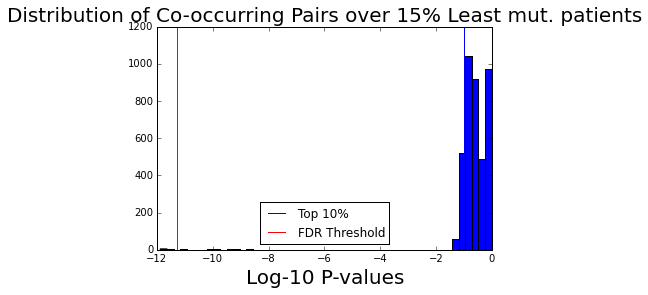

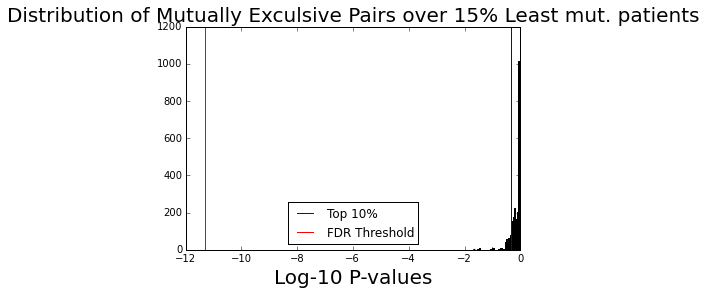

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)

threshold = 0.05/len(logcp)

cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold or pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of pairs to test ", len(goodpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.axvline(x=np.log(threshold), label="FDR Threshold", c='r')
plt.title("Distribution of Co-occurring Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()




threshold = 0.05/len(logmp)

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.axvline(x=np.log(threshold), label="FDR Threshold", c='r')
plt.title("Distribution of Mutually Exculsive Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



In [18]:
new_pairsdict, new_genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodpairs, compute_mutex=compute_mutex)

print "number of pairs is ", len(new_pairsdict)
print "Getting cooccurrence across the whole distribution"

new_pairsdict = chi.add_BinomP_cohorts_all_pairs(new_pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_pairsdict = chi.add_BinomP_all_pairs(new_pairsdict, geneToCases, patientToGenes)
print "Writing to file...", new_cpairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('BinomProbability')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'BinomProbability')

met.writeanydict(new_pairsdict, new_cpairfile, fieldnames=fieldnames)
os.system('say "finished"')

number of pairs is  825
Getting cooccurrence across the whole distribution
Writing to file... /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-seg-jl--cpairs-min_cohort_filtered.txt


0

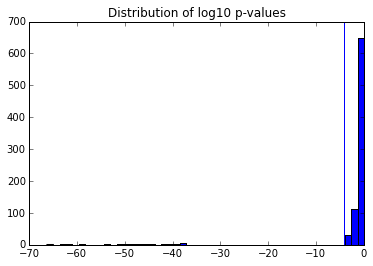

Number of significant pairs  31


In [19]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_pairsdict[c]['BinomProbability'] for c in pairsdict if  ])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)

threshold = 0.05/len(logcp)

# Let's get the top 10 percent of pairs

goodpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold or pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of pairs to test ", len(goodpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.axvline(x=np.log(threshold), label="FDR Threshold", c='r')
plt.title("Distribution of Co-occurring Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()




threshold = 0.05/len(logmp)

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.axvline(x=np.log(threshold), label="FDR Threshold", c='r')
plt.title("Distribution of Mutually Exculsive Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



sig = [pvalue for pvalue in pvalues if pvalue < threshold]
print "Number of significant pairs ", len(sig)

# filter all the pairs

new_dict = new_pairsdict.copy()
for pair in new_pairsdict:
    if new_dict[pair]['BinomProbability'] > threshold:
        new_dict.pop(pair)
        
new_pairsdict = new_dict.copy()

In [20]:
# add the segment infos

bgbp.write_segment_infos(goodgenes, segment_info_file)

gene_dict = {}
cyto_dict = {}
cyto_pair_dict = {}

for pair in new_pairsdict:
    info0 = bgbp.get_segment_gene_info(new_pairsdict[pair]['Gene0'])
    new_pairsdict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_pairsdict[pair]['Gene1'])
    new_pairsdict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_pairsdict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_pairsdict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_pairsdict[pair]['Gene0'] not in gene_dict:
        gene_dict[new_pairsdict[pair]['Gene0']] = set()
    gene_dict[new_pairsdict[pair]['Gene0']].add(pair)
    if new_pairsdict[pair]['Gene1'] not in gene_dict:
        gene_dict[new_pairsdict[pair]['Gene1']] = set()
    gene_dict[new_pairsdict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) not in cyto_dict:
        cyto_dict[str(info0['Cytobands'])] = set()
    cyto_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) not in cyto_dict:
        cyto_dict[str(info1['Cytobands'])] = set()
    cyto_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']), str(info1['Cytobands'])])
    
    if cyto_pair not in cyto_pair_dict:
        cyto_pair_dict[cyto_pair] = set()
        
    cyto_pair_dict[cyto_pair].add(pair)
    
# Writing to file
if 'Gene0Loc' not in fieldnames:
    fieldnames.append('Gene0Loc')
if 'Gene1Loc' not in fieldnames:
    fieldnames.append('Gene1Loc')
if 'Gene0Cytobands' not in fieldnames:
    fieldnames.insert(2, 'Gene0Cytobands')
if 'Gene1Cytobands' not in fieldnames:
    fieldnames.insert(3, 'Gene1Cytobands')

met.writeanydict(new_pairsdict, new_cpairfile, fieldnames=fieldnames)
print "updated with segment info ", new_cpairfile



# Writing gene infos
    

sorted_genes = sorted(gene_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])

    
    
    
    
    

    

os.system('say "finished"')

updated with segment info  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-seg-jl--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
FAM230Closs has 19
RN7SL605Ploss has 12
TBC1D22Aloss has 1
ZNRF3_C22orf31_loss has	1
SEZ6L_RNA5SP495loss has	1
RN7SL757Ploss has 1
AIPL1_FAM64A_KIloss has	1
HS3ST3A1_MIR548loss has	1
MAP2K4_MIR744loss has 1
MYH13_MYH8_MYH4loss has	1
CYB5D1_CHD3_KCNloss has	1
PPM1F_TOP3B_VPRloss has	1
YWHAEloss has 1
IGLL1_GUSBP11_Rloss has	1
LINC00898loss has 1
LARGEloss has 1
RN7SL162P_CHEK2loss has	1
LINC00670_MYOCDloss has	1
MIR4764loss has 1
WSCD1loss has 1
OR11H1_POTEH_KCloss has	1
HMGXB4_TOM1_MIRloss has	1
TXN2_FOXRED2_EIloss has	1
DOC2B_RPH3AL_C1loss has	1
ISXloss has 1
CRK_MYO1C_INPP5loss has	1
STX8_USP43_DHRSloss has	1
DNAH9_ZNF18_RPLloss has	1
MIR3201_FAM19A5loss has	1
TTC28loss has 1
MAPK1_RNA5SP493loss has 1
PEX26_TUBA8_USPloss has	1
MN1_PITPNBloss has 1

**********SINGLE CYTOBANDS**********
['13q11'] has 19
[

0

In [21]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg

pairsdict = new_pairsdict.copy()
genedict = edg.get_gene_dict(pairsdict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(pairsdict, genedict, pairsdict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    met.writeTriplets(Triplet_dict[t_type], triplet_file_prefix + t_type + '.txt')


number of pairs  31
Pair info of triplets initialized
0  triplets calculated in  0.000618934631348
Including sorting time  0.00074291229248
